In [23]:
import pandas as pd
import seaborn as sns
import pathlib
import matplotlib.pyplot as plt
import numpy as np

In [2]:
DATA_DIR = pathlib.Path("../data")

In [12]:
dataframes = {}
splits = {}
for dataset in ("adme_microsom_stab_r", "adme_microsom_stab_h"):
    df = pd.read_csv(DATA_DIR / f"{dataset}.csv")
    dataframes[dataset] = df
    splits[dataset] = {}
    for split_type in ("datasail", "scaffold", "random"):
        splits[dataset][split_type] = list(DATA_DIR.glob(f"{dataset}_*.{split_type}_splits.json"))
    
    

In [114]:
def plot_distribution(data, ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    sns.stripplot(data, dodge=True, orient="h", jitter=0.4, s=3, ax=ax)
    sns.boxplot(y=1, x=data, ax=ax, orient="h", fill=False, color="blue")

def plot_frames(frames):
    fig, axes = plt.subplots(1, 2)
    for (name, df), ax in zip(frames.items(), axes):
        plot_distribution(df[df.columns[1]], ax)

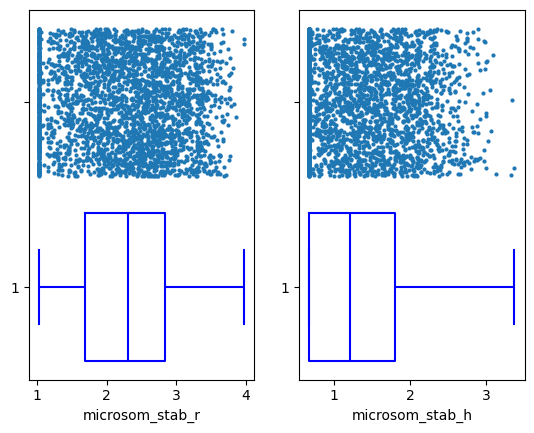

In [115]:
plot_frames(dataframes)

In [128]:
cleaned_datasets = {}
n_removed = {}
for name, df in dataframes.items():
    target_col = df.columns[1]
    is_censored = df[target_col] == df[target_col].min()
    cleaned_datasets[name] = df[~is_censored]

    n_removed[name] = sum(is_censored)
    print(f"before: {len(df)}, now: {len(df[~is_censored])} ({sum(is_censored)} censored values)")

before: 3054, now: 2708 (346 censored values)
before: 3087, now: 2129 (958 censored values)


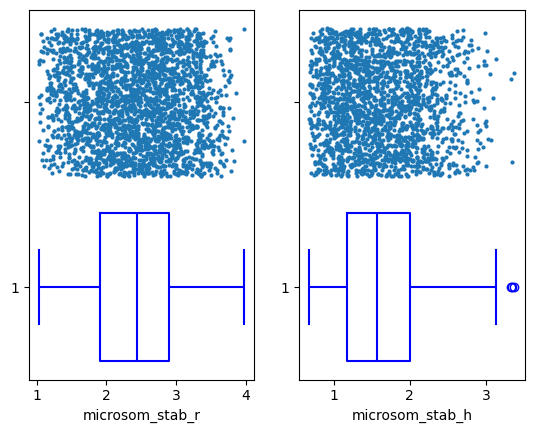

In [129]:
plot_frames(cleaned_datasets)

Now we need to update all splits, to remove any indices that are not in the cleaned dataset

In [147]:
import json

for dataset, splits_by_type in splits.items():

    df = cleaned_datasets[dataset]

    
    for split_type, split_paths in splits_by_type.items():

        for path in split_paths:
            content = path.read_text()
            splitting = json.loads(content)

            cleaned_splitting = {}
            diff = 0
            for split_name, split in splitting.items():

                cleaned_split = [idx for idx in split if idx in df.index]
                cleaned_splitting[split_name] = cleaned_split
                diff += len(split) - len(cleaned_split)
            assert diff == n_removed[dataset]  # Sanity check

            # Check train/val/test set balancing 
            total_before = sum(len(x) for x in splitting.values())
            balance_before = [len(x) / total_before for x in splitting.values()]
            total_now = sum(len(x) for x in cleaned_splitting.values())
            balance_now = [len(x) / total_now for x in cleaned_splitting.values()]

            print(f"{balance_before} -> {balance_now}")

            output_file = path.parent / (dataset + "_cleaned" + path.stem.removeprefix(dataset) + ".json")
            with open(output_file, "w") as f:
                json.dump(cleaned_splitting, f, indent=2)

[0.610347085789129, 0.1922069417157826, 0.1974459724950884] -> [0.611890694239291, 0.19387001477104873, 0.19423929098966028]
[0.611984282907662, 0.1974459724950884, 0.1905697445972495] -> [0.6148449039881831, 0.19423929098966028, 0.19091580502215658]
[0.5805500982318271, 0.1905697445972495, 0.2288801571709234] -> [0.5875184638109305, 0.19091580502215658, 0.22156573116691286]
[0.5802226588081205, 0.2288801571709234, 0.19089718402095612] -> [0.5790251107828656, 0.22156573116691286, 0.19940915805022155]
[0.6168958742632613, 0.19089718402095612, 0.1922069417157826] -> [0.6067208271787297, 0.19940915805022155, 0.19387001477104873]
[0.09986902423051736, 0.09986902423051736, 0.8002619515389653] -> [0.10007385524372231, 0.09859675036927622, 0.8013293943870015]
[0.09986902423051736, 0.09986902423051736, 0.8002619515389653] -> [0.09933530280649926, 0.09379615952732644, 0.8068685376661743]
[0.09986902423051736, 0.09986902423051736, 0.8002619515389653] -> [0.10118168389955687, 0.09711964549483014,